In [1]:
import os
import random
import pandas as pd 
import numpy as np
from numpy import array
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling1D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#  1-Création modèle

In [2]:
class NeuralNetwork():
    """Création d'un réseau de neuronnes """    

    def __init__(self):
        self.model_name = "model_stress_rest_final"
        self.model = Sequential()
        self.epochs = 35
    
    def get_data(self):
        """Chargement de la data de la variabilité de la fréquence cardiaque"""
       
        # Rend le nombre aléatoire prédictible, pour rendre le modèle reproductible
        seed = 7
        np.random.seed(seed)
        
        # Mélange aléatoirement les lignes du fichier csv
        with open("/home/fsz/Bureau/Développement/sauvegarde_extraction/all_measures_new17.csv",'r') as source:
            data = [ (random.random(), line) for line in source ]
            data.sort()
        with open('another_file.csv','w') as target:
            for _, line in data:
                target.write( line )

        # Chargement de la data mélangée 
        columns = ['bpm','rmssd','balance_sv','sdnn','state']
        dataframe = pd.read_csv('another_file.csv')
        dataset = dataframe.values
      
        # Séparation mesures numérique et état correspondant au label de notre classe
        self.X = dataset[:,0:4].astype(float)
     
        #self.X = dataset[:,0:6].astype(float)
        self.nb_sample = len(self.X)
        self.Y = dataset[:,4]
        
        
    def encode_label(self):
        """Encode les valeurs de classes en entier"""
        
        encoder = LabelEncoder()
        encoder.fit(self.Y)
        encoded_Y = encoder.transform(self.Y)
        
        # Converti les entiers en variables nominales
        self.dummy_y = np_utils.to_categorical(encoded_Y)
        
    def define_model(self):
        """Création du modèle"""
        
        self.model.add(Dense(64,input_dim=4,kernel_initializer='normal', activation='relu' ))
        self.model.add(Dropout(0.5))
        self.model.add(BatchNormalization())
       
        self.model.add(Dense(32,activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(BatchNormalization())
        
        self.model.add(Dense(8,activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(BatchNormalization())
        
        self.model.add(Dense(2, kernel_initializer='normal',activation='softmax'))
        
        b_s = int(self.nb_sample/self.epochs)
        self.model.compile(loss='binary_crossentropy', optimizer='adamax',metrics=['accuracy'])
        self.history = self.model.fit(self.X, self.dummy_y, validation_split=0.2,batch_size = 40,epochs=self.epochs, verbose=1)

    def save_model(self):
        """Sauvegarde du modèle"""
        self.model.save(self.model_name+".h5")
        print("Sauvegarde")
        
    def history_model(self):
        """Affichage des graph accuracy et loss"""
        
        # Historique accuracy
        plt.plot(self.history.history['acc'])
        plt.plot(self.history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        # Historique loss
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def run(self):
        self.get_data()
        self.encode_label()
        self.define_model()
        self.save_model()
        self.history_model()
        
  

In [3]:
def train_model():
    neural_network = NeuralNetwork()
    neural_network.run()    

40
Train on 1134 samples, validate on 284 samples
Epoch 1/35
1134/1134 [==============================] - 0s - loss: 0.6891 - acc: 0.5115 - val_loss: 0.6629 - val_acc: 0.6373
Epoch 2/35
1134/1134 [==============================] - 0s - loss: 0.6678 - acc: 0.5944 - val_loss: 0.6546 - val_acc: 0.7254
Epoch 3/35
1134/1134 [==============================] - 0s - loss: 0.6650 - acc: 0.6023 - val_loss: 0.6457 - val_acc: 0.7324
Epoch 4/35
1134/1134 [==============================] - 0s - loss: 0.6446 - acc: 0.6534 - val_loss: 0.6401 - val_acc: 0.6549
Epoch 5/35
1134/1134 [==============================] - 0s - loss: 0.6329 - acc: 0.6499 - val_loss: 0.6211 - val_acc: 0.7042
Epoch 6/35
1134/1134 [==============================] - 0s - loss: 0.6164 - acc: 0.6561 - val_loss: 0.6016 - val_acc: 0.7113
Epoch 7/35
1134/1134 [==============================] - 0s - loss: 0.5918 - acc: 0.7037 - val_loss: 0.5691 - val_acc: 0.7676
Epoch 8/35
1134/1134 [==============================] - 0s - loss: 0.5605 -

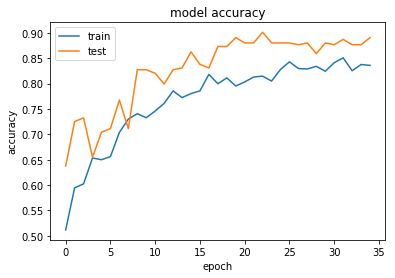

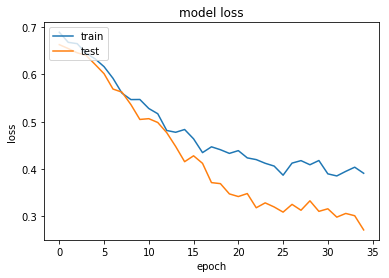

In [4]:
train_model()

   # 2-Test classification

In [5]:
class TestModel():
    """Test du modèle de classification stress / repos """

    def __init__(self):
        self.model_path = "model_stress_rest_final.h5"
        self.data_stress_path = "/home/fsz/Bureau/Développement/sauvegarde_extraction/stress_test.csv"
        self.data_rest_path = "/home/fsz/Bureau/Développement/sauvegarde_extraction/rest_test.csv"
        self.columns_name = ['bpm','rmssd','balance_sv','sdnn','phase']
        self.model = load_model(self.model_path)
        
    def get_data_test(self):
        """Obtention de la data de test"""
        self.data_stress =  pd.read_csv(self.data_stress_path,names=self.columns_name)
        self.data_rest = pd.read_csv(self.data_rest_path,names=self.columns_name)
        
    def evaluate_rest_classification(self):
        """Evaluation de la précision du modèle sur la data de la phase relaxation"""
        bpm_rest = self.data_rest.bpm.tolist()
        rmssd_rest = self.data_rest.rmssd.tolist()
        balance_sv_rest = self.data_rest.balance_sv.tolist()
        sdnn_rest = self.data_rest.sdnn.tolist()
        data_list = []
        
        i = 0
        while i < len(bpm_rest) - 1:
            X = array([[bpm_rest[i],rmssd_rest[i],balance_sv_rest[i],sdnn_rest[i]]])
            data_list.append(self.model.predict_classes(X))
            i+=1

        corrected_prediction = data_list.count(array([0]))
        self.number_samples_rest = len(data_list)
        self.accuracy_rest = corrected_prediction/self.number_samples_rest
        
    def evaluate_stress_classification(self):
        """Evaluation de la précision du modèle sur la data de la phase de stress"""
        bpm_stress = self.data_stress.bpm.tolist()
        rmssd_stress = self.data_stress.rmssd.tolist()
        balance_sv_stress = self.data_stress.balance_sv.tolist()
        sdnn_stress = self.data_stress.sdnn.tolist()
        data_list = []
        
        i = 0
        while i < len(bpm_stress) - 1:
            X = array([[bpm_stress[i],rmssd_stress[i],balance_sv_stress[i],sdnn_stress[i]]])
            data_list.append(self.model.predict_classes(X))
            i+=1

        corrected_prediction = data_list.count(array([1]))
        self.number_samples_stress = len(data_list)
        self.accuracy_stress = corrected_prediction/self.number_samples_stress
        
    def evaluate_model(self):
        """Evaluation des performances de l'ensemble du modèle"""
        samples_well_classified = self.number_samples_rest*self.accuracy_rest + self.number_samples_stress*self.accuracy_stress
        accuracy = samples_well_classified/(self.number_samples_rest+self.number_samples_stress)
        print("Nombre de samples correctement classifiés:",samples_well_classified)
        print("Pourcentage de samples correctement classifiés:",accuracy)
        
    def run_test(self):
        self.get_data_test()
        self.evaluate_rest_classification()
        self.evaluate_stress_classification()
        self.evaluate_model()
        

In [6]:
test_model = TestModel()
test_model.run_test()

1/1 [==============================] - 0s


1/1 [==============================] - 0s


1/1 [==============================] - 0s
Nombre de samples correctement classifiés: 833.0
Pourcentage de samples correctement classifiés: 0.8305084745762712
